In [375]:
import warnings

import h2o
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from h2o.automl import H2OAutoML
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings("ignore")


In [376]:
# Carga de datos
df_survey = pd.read_pickle(filepath_or_buffer="data/df_survey.pkl")
y = "covid19"
ignore = ["covid19"]
x = list(set(df_survey.columns) - set(ignore))

In [377]:
# Define the numeric and categorical features
numeric_features = [
    "id_bio_age",
    "id_bio_weight",
    "id_bio_height",
    "id_mat_18_plus_household_members",
    "id_mat_total_household_members",
]
categorical_features = list(set(x) - set(numeric_features))

scaler = MinMaxScaler()
df_survey_imputed_num = pd.DataFrame(scaler.fit_transform(df_survey[x]), columns=x)
imputer = KNNImputer(n_neighbors=10)
df_survey_imputed_num = pd.DataFrame(
    imputer.fit_transform(df_survey_imputed_num), columns=df_survey_imputed_num.columns
)
df_survey_imputed_num = df_survey_imputed_num[numeric_features]

# Define the transformers for numeric and categorical features
# numeric_transformer = Pipeline(
#     # steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
#     steps=[("imputer", KNNImputer(n_neighbors=5)), ("scaler", StandardScaler())]
# )

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Fit and transform the data
df_survey_imputed_cat = preprocessor.fit_transform(df_survey[x])

df_survey_imputed = pd.DataFrame(
    np.concatenate([df_survey_imputed_num, df_survey_imputed_cat], axis=1),
    columns=numeric_features + categorical_features,
)

df_survey_imputed.head()

,id_bio_age,id_bio_weight,id_bio_height,id_mat_18_plus_household_members,id_mat_total_household_members,id_bio_outside_bubble_contag,sd_inc_income_problems,id_psy_anxiety_sympt,sd_occ_current_job,sd_cul_holiday_season,...,id_beh_risk_others,id_beh_risk_personal,id_beh_physical_act,id_bio_death_covid,sd_inc_income_level,sd_cul_religion,id_bio_comorbidities,id_bio_disability,id_beh_percep_severity,id_bio_bubble_contag
0,0.492754,0.787879,0.78,0.105263,0.105263,1.0,0.0,0.0,1.0,2.0,...,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0
1,0.724638,0.560606,0.71,0.105263,0.105263,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0
2,0.260870,0.893939,0.71,0.052632,0.105263,1.0,1.0,0.0,1.0,2.0,...,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0
3,0.869565,0.393939,0.50,0.052632,0.052632,0.0,1.0,0.0,1.0,2.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0
4,0.028986,0.712121,0.80,0.210526,0.210526,1.0,0.0,0.0,1.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [378]:
X_train, X_test, y_train, y_test = train_test_split(
    df_survey_imputed,
    df_survey[y],
    test_size=0.2,
    random_state=40,
    stratify=df_survey[y],
)


print("#" * 5 + " Split sample " + "#" * 5)
print("train:%d, test:%d" % (len(y_train.index), len(y_test.index)))
print("#" * 5 + " Distribution Train Sample " + "#" * 5)
print(y_train.value_counts() / len(y_train))
print("#" * 5 + " Distribution Test Sample " + "#" * 5)
print(y_test.value_counts() / len(y_test))

train = pd.concat([y_train, X_train], axis=1)
test = pd.concat([y_test, X_test], axis=1)

##### Split sample #####
train:1602, test:401
##### Distribution Train Sample #####
covid19
False    0.730961
True     0.269039
Name: count, dtype: float64
##### Distribution Test Sample #####
covid19
False    0.730673
True     0.269327
Name: count, dtype: float64


In [379]:
# Inicializar h2o
# h2o.cluster().shutdown()

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,19 hours 53 mins
H2O_cluster_timezone:,America/Costa_Rica
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 7 days
H2O_cluster_name:,H2O_from_python_maikol_xy3lw8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.268 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [380]:
train.columns


Index(['covid19', 'id_bio_age', 'id_bio_weight', 'id_bio_height',
       'id_mat_18_plus_household_members', 'id_mat_total_household_members',
       'id_bio_outside_bubble_contag', 'sd_inc_income_problems',
       'id_psy_anxiety_sympt', 'sd_occ_current_job', 'sd_cul_holiday_season',
       'sd_edu_scholarity', 'id_bio_vaccination_status',
       'sd_eth_is_costa_rican', 'id_bio_masculine', 'id_beh_percep_contag',
       'id_psy_vaccination_myths', 'id_beh_risk_others',
       'id_beh_risk_personal', 'id_beh_physical_act', 'id_bio_death_covid',
       'sd_inc_income_level', 'sd_cul_religion', 'id_bio_comorbidities',
       'id_bio_disability', 'id_beh_percep_severity', 'id_bio_bubble_contag'],
      dtype='object')

In [381]:
# Convertir a h2o
col_types = {
    "covid19": "enum",
    "id_beh_percep_contag": "enum",
    "id_beh_percep_severity": "enum",
    "id_bio_bubble_contag": "enum",
    "id_bio_outside_bubble_contag": "enum",
    "id_bio_death_covid": "enum",
    "id_beh_risk_personal": "enum",
    "id_beh_risk_others": "enum",
    "id_beh_physical_act": "enum",
    "id_psy_vaccination_myths": "enum",
    "id_bio_vaccination_status": "enum",
    "id_psy_anxiety_sympt": "enum",
    "sd_inc_income_problems": "enum",
    "sd_inc_income_level": "enum",
    "sd_cul_holiday_season": "enum",
    "id_bio_masculine": "enum",
    "id_bio_age": "numeric",
    "id_bio_weight": "numeric",
    "id_bio_height": "numeric",
    "sd_edu_scholarity": "enum",
    "sd_occ_current_job": "enum",
    "sd_eth_is_costa_rican": "enum",
    "id_bio_comorbidities": "enum",
    "sd_cul_religion": "enum",
    "id_bio_disability": "enum",
    "id_mat_18_plus_household_members": "numeric",
    "id_mat_total_household_members": "numeric",
}

train_h2o = h2o.H2OFrame(train, column_types=col_types)
test_h2o = h2o.H2OFrame(test, column_types=col_types)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [382]:
train_h2o.types


{'covid19': 'enum',
 'id_bio_age': 'real',
 'id_bio_weight': 'real',
 'id_bio_height': 'real',
 'id_mat_18_plus_household_members': 'real',
 'id_mat_total_household_members': 'real',
 'id_bio_outside_bubble_contag': 'enum',
 'sd_inc_income_problems': 'enum',
 'id_psy_anxiety_sympt': 'enum',
 'sd_occ_current_job': 'enum',
 'sd_cul_holiday_season': 'enum',
 'sd_edu_scholarity': 'enum',
 'id_bio_vaccination_status': 'enum',
 'sd_eth_is_costa_rican': 'enum',
 'id_bio_masculine': 'enum',
 'id_beh_percep_contag': 'enum',
 'id_psy_vaccination_myths': 'enum',
 'id_beh_risk_others': 'enum',
 'id_beh_risk_personal': 'enum',
 'id_beh_physical_act': 'enum',
 'id_bio_death_covid': 'enum',
 'sd_inc_income_level': 'enum',
 'sd_cul_religion': 'enum',
 'id_bio_comorbidities': 'enum',
 'id_bio_disability': 'enum',
 'id_beh_percep_severity': 'enum',
 'id_bio_bubble_contag': 'enum'}

In [383]:
max_models = 500
excluded_algos = ["StackedEnsemble", "DeepLearning"]

# Definir modelo y entrenar
aml = H2OAutoML(
    nfolds=10,
    max_models=max_models,
    max_runtime_secs=3600,
    seed=42,
    stopping_metric="aucpr",
    sort_metric="aucpr",
    balance_classes=False,
    exclude_algos=excluded_algos,
)

In [384]:
aml.train(y=y, training_frame=train_h2o)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_7_20230930_101814_model_370


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    24                 24                          3949                   3            6            4.66667       7             9             8.45833

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1363547665659648
RMSE: 0.3692624629798767
LogLoss: 0.4292127404048759
Mean Per-Class Error: 0.20846402127200064
AUC: 0.8588847654353766
AUCPR: 0.6974058492004732
Gini: 0.7177695308707532

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20463361599081697
       False    True    Error    Rate
-----  -------  ------  -------  --------------
False  911      260     0.222    (260.0/1171.0)
True   84       347     0.1949   (84.0/431.0)
Total  995      607     0.2147   (344.0/1602.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.204634     0.668593  235
max f2                       0.161844     0.768156  273
max f0point5                 0.453793     0.651054  155
max accuracy                 0.453793     0.81211   155
max precision                0.705831     1         0
max recall                   0.0947165    1         377
max specificity              0.705831     1         0
max absolute_mcc             0.204634     0.533008  235
max min_per_class_accuracy   0.21289      0.783091  230
max mean_per_class_accuracy  0.204634     0.791536  235
max tns                      0.705831     1171      0
max fns                      0.705831     430       0
max fps                      0.0717591    1171      399
max tps                      0.0947165    431       377
max tnr                      0.705831     1         0
max fnr                      0.705831     0.99768   0
max fpr                      0.0717591    1         399
max tpr                      0.0947165    1         377

Gains/Lift Table: Avg response rate: 26.90 %, avg score: 26.83 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0106117                   0.667564           3.71694    3.71694            1                0.682741  1                           0.682741            0.0394432       0.0394432                  271.694   271.694            0.0394432
2        0.0205993                   0.633455           3.48463    3.6043             0.9375           0.64403   0.969697                    0.663972            0.0348028       0.0742459                  248.463   260.43             0.073392
3        0.0305868                   0.615141           3.25232    3.48937            0.875            0.62186   0.938776                    0.650221            0.0324826       0.106729                   225.232   248.937            0.104167
4        0.0405743                   0.607768           3.48463    3.4882             0.9375           0.611048  0.938462                    0.640579            0.0348028       0.141531                   248.463   248.82             0.138115
5        0.0505618                   0.597428           2.7877     3.34983            0.75             0.60208

In [385]:
h2o.save_model(
    aml.leader,
    path="models/",
    force=True,
    filename="aml_leader_model",
    export_cross_validation_predictions=True,
)


'/Users/maikol/OneDrive/home/documents/2023/2023_03_paper_triageml_cr2021/Paper-COVID-MLTriage-CR2021/models/aml_leader_model'

In [386]:
aml.leader.algo


'gbm'

In [387]:
aml.leader.save_model_details(
    path="models/", force=True, filename="aml_leader_model_details"
)

'/Users/maikol/OneDrive/home/documents/2023/2023_03_paper_triageml_cr2021/Paper-COVID-MLTriage-CR2021/models/aml_leader_model_details'

In [388]:
aml.leader.summary()


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,24.0,24.0,3949.0,3.0,6.0,4.6666665,7.0,9.0,8.458333


In [389]:
# Performance del modelo

perf = aml.leader.model_performance(test_data=test_h2o)
prevalence = sum(df_survey.covid19) / len(df_survey)
threshold = perf.F1()[0][0]
sensitivity = perf.recall(thresholds=[threshold])[0][1]
specificity = perf.specificity(thresholds=[threshold])[0][1]
F1 = perf.F1(thresholds=[threshold])[0][1]
AUC = perf.auc()
AUC_PR = perf.aucpr()
precision = perf.precision(thresholds=[threshold])[0][1]
accuracy = perf.accuracy(thresholds=[threshold])[0][1]


print("Prevalence", prevalence)
print("Threshold", threshold)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("F1:", F1)
print("AUC:", AUC)
print("AUC_PR:", AUC_PR)
print(perf.confusion_matrix(thresholds=[threshold]))

Prevalence 0.2690963554667998
Threshold 0.4251002507102708
Sensitivity: 0.7777777777777778
Specificity: 0.7952218430034129
Precision: 0.5833333333333334
Accuracy: 0.7905236907730673
F1: 0.6666666666666666
AUC: 0.8131715333080521
AUC_PR: 0.5687057766010317
Confusion Matrix (Act/Pred) @ threshold = 0.4251002507102708
       False    True    Error    Rate
-----  -------  ------  -------  ------------
False  233      60      0.2048   (60.0/293.0)
True   24       84      0.2222   (24.0/108.0)
Total  257      144     0.2095   (84.0/401.0)


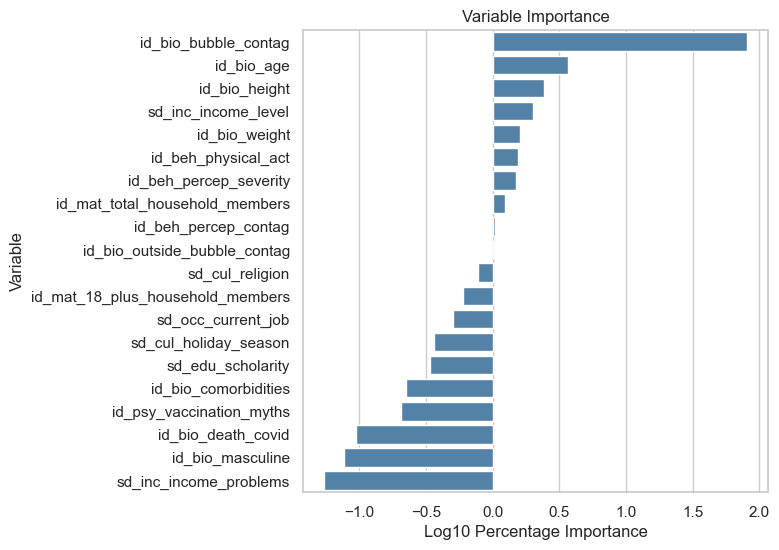

In [390]:
# Get variable importance data
var_imp = aml.leader.varimp(use_pandas=True)

# Filter only the variables with positive scaled_importance value
var_imp = var_imp[var_imp["percentage"] > 0]
var_imp["log_scaled_importance"] = np.log10(var_imp["percentage"] * 100)

h = 6
w = 6
# Create plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(w, h))  # set the figure size
sns.barplot(x="log_scaled_importance", y="variable",
            data=var_imp, color="steelblue")

# Set informative labels for the plot
plt.title("Variable Importance")
plt.xlabel("Log10 Percentage Importance")
plt.ylabel("Variable")

# Set the x-axis limits to adjust the scale
# plt.xlim(0, 1)

# Save plot to pdf file
plt.savefig("img/plot_var_imp.pdf", bbox_inches="tight")
plt.show()


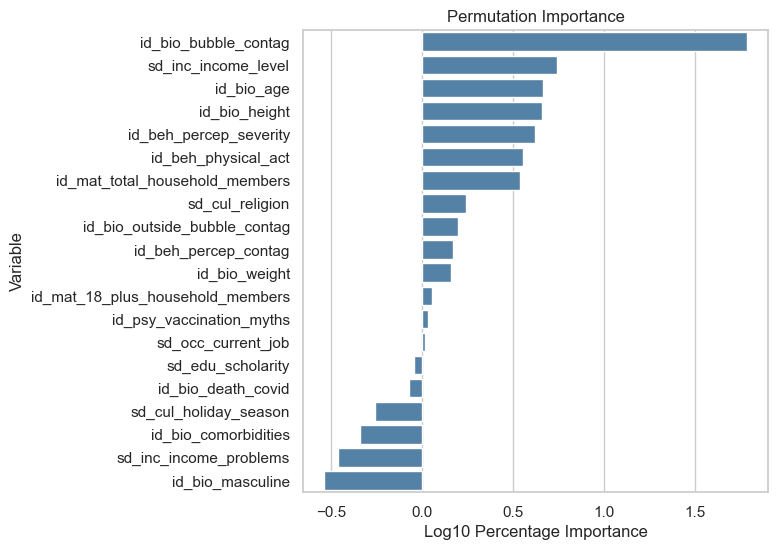

In [391]:
perm_imp = aml.leader.permutation_importance(
    frame=test_h2o, n_repeats=100, metric="PR_AUC", seed=42
)
perm_imp = perm_imp.as_data_frame()
perm_imp["mean"] = perm_imp[perm_imp.columns[1:]].mean(axis=1)
perm_imp = perm_imp.sort_values(by="mean", ascending=False)
perm_imp["Scaled Importance"] = perm_imp["mean"] / perm_imp["mean"].sum()

# perm_imp = perm_imp.as_data_frame()
perm_imp = perm_imp[perm_imp["Scaled Importance"] > 0]
perm_imp["log_scaled_importance"] = np.log10(
    perm_imp["Scaled Importance"] * 100)

h = 6
w = 6
# Create plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(w, h))  # set the figure size
sns.barplot(x="log_scaled_importance", y="Variable",
            data=perm_imp, color="steelblue")

# Set informative labels for the plot
plt.title("Permutation Importance")
plt.xlabel("Log10 Percentage Importance")
plt.ylabel("Variable")

# Set the x-axis limits to adjust the scale
# plt.xlim(0, 1)

# Save plot to pdf file
plt.savefig("img/plot_perm_imp.pdf", bbox_inches="tight")
plt.show()


<Figure size 970.8x600 with 0 Axes>

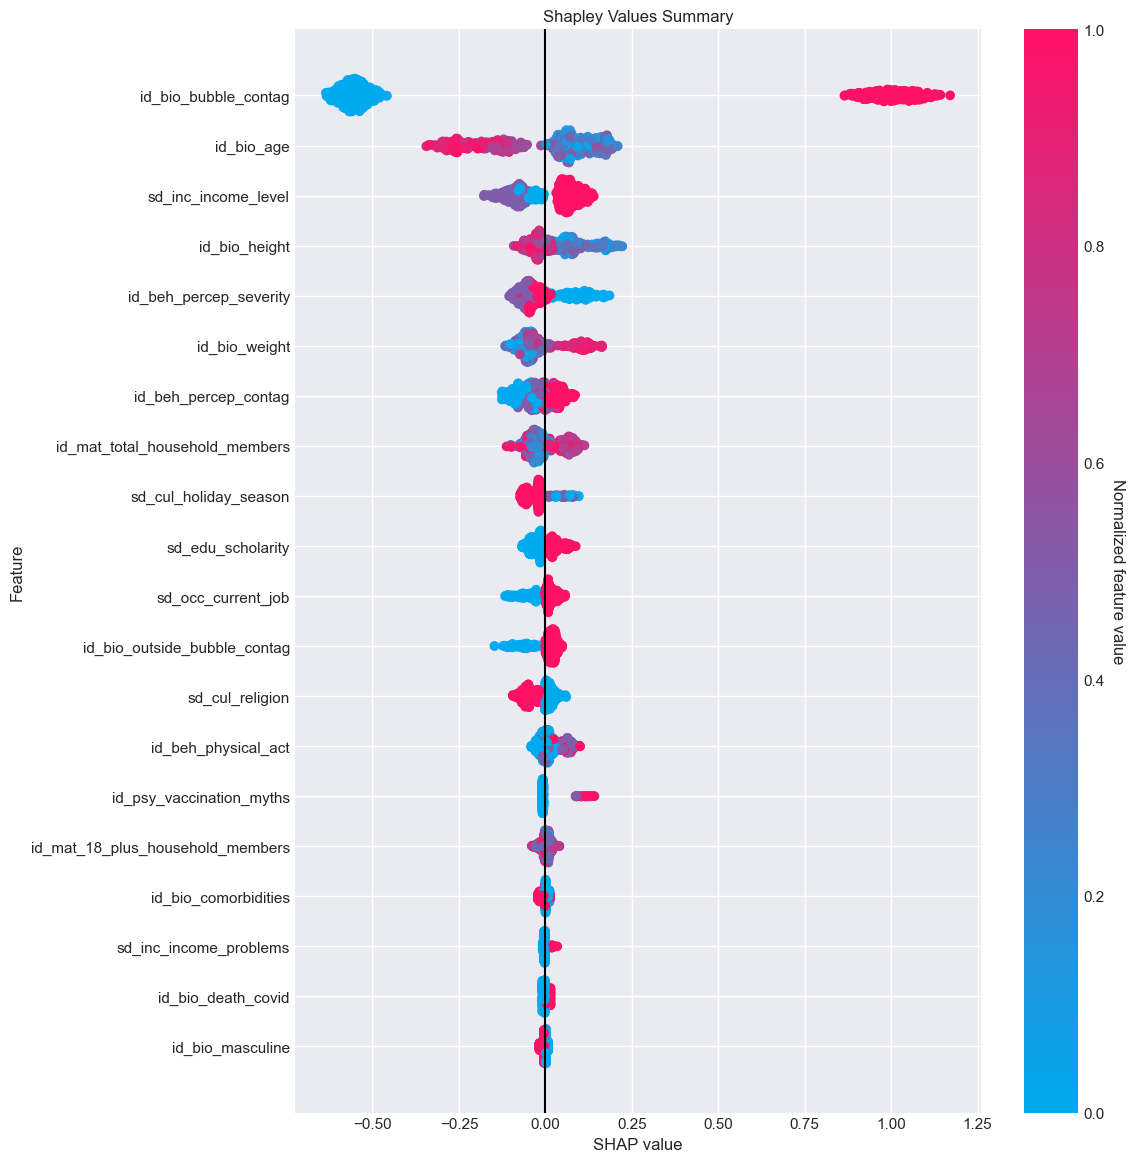

In [392]:
h = 6
w = h * 1.618
plt.rc("font", size=19)
plt.style.use("seaborn-v0_8-dark")
plt.figure(figsize=(w, h))  # set the figure size


shap_plot = aml.leader.shap_summary_plot(test_h2o, alpha=1, samples=3000)


plt.title("Shapley Values Summary")
plt.savefig("img/plot_shap.pdf", bbox_inches="tight")

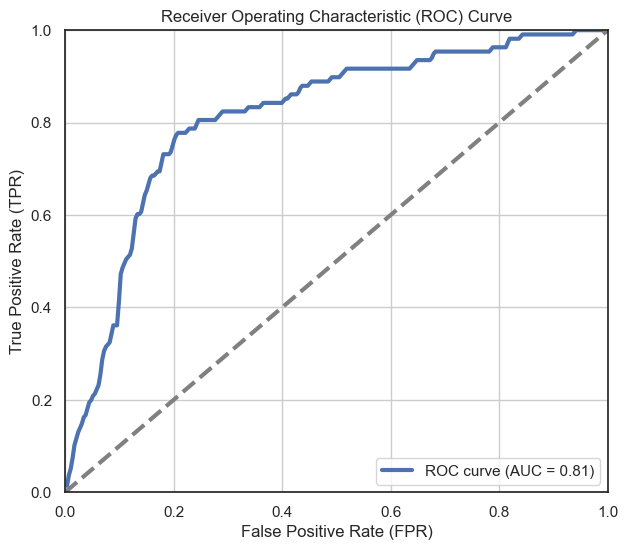

In [393]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

matplotlib.style.use("default")
fprs = perf.fprs
tprs = perf.tprs
auc = perf.auc()

df = pd.DataFrame({"fpr": fprs, "tpr": tprs})

sns.set_theme(style="white")
plt.figure(figsize=(7, 6))
sns.lineplot(
    x="fpr",
    y="tpr",
    lw=3,
    data=df,
    err_style=None,
    label="ROC curve (AUC = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="gray", lw=3, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("img/plot_roc.pdf", bbox_inches="tight")
plt.show()


In [403]:
precision = perf.precision(thresholds="all")
recall = perf.recall(thresholds="all")
pr_auc = perf.pr_auc()

precision = [t[1] for t in precision]
recall = [t[1] for t in recall]


list

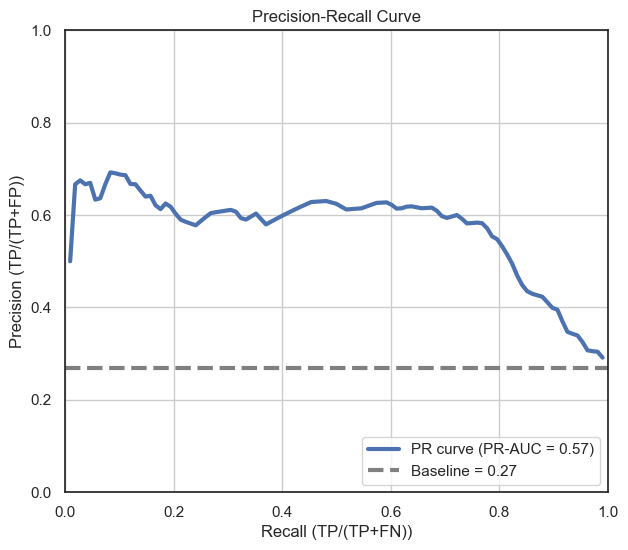

In [404]:
import seaborn as sns
import pandas as pd

precision = perf.precision(thresholds="all")
recall = perf.recall(thresholds="all")
pr_auc = perf.pr_auc()

precision = [t[1] for t in precision]
recall = [t[1] for t in recall]

df = pd.DataFrame({"Recall": recall, "Precision": precision})

df = df.query("Recall >0 & Recall < 1 & Precision >0 & Precision < 1")

sns.set_theme(style="white")
plt.figure(figsize=(7, 6))
sns.lineplot(
    x="Recall",
    y="Precision",
    lw=3,
    data=df,
    err_style=None,
    label="PR curve (PR-AUC = %0.2f)" % pr_auc,
)
plt.plot(
    [0, 1],
    [prevalence, prevalence],
    color="gray",
    lw=3,
    linestyle="--",
    label="Baseline = %0.2f" % prevalence,
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Recall (TP/(TP+FN))")
plt.ylabel("Precision (TP/(TP+FP))")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("img/plot_pr.pdf", bbox_inches="tight")
plt.show()


In [395]:
# Variable importance
aml.leader.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,id_bio_bubble_contag,420.697235,1.000000,0.806843
1,id_bio_age,19.286972,0.045845,0.036990
2,id_bio_height,12.659248,0.030091,0.024279
3,sd_inc_income_level,10.458688,0.024860,0.020058
4,id_bio_weight,8.341608,0.019828,0.015998
5,id_beh_physical_act,8.104297,0.019264,0.015543
6,id_beh_percep_severity,7.837235,0.018629,0.015031
7,id_mat_total_household_members,6.486504,0.015418,0.012440
8,id_beh_percep_contag,5.414029,0.012869,0.010383
9,id_bio_outside_bubble_contag,5.220945,0.012410,0.010013


In [396]:
# Permutation importance
aml.leader.permutation_importance(
    frame=test_h2o, n_repeats=5, metric="PR_AUC", use_pandas=True
)

,Run 1,Run 2,Run 3,Run 4,Run 5
Variable,,,,,
id_bio_bubble_contag,0.260372,0.274155,0.246224,0.276619,0.289679
id_beh_percep_severity,0.044191,0.008382,0.019489,0.018961,0.033166
id_beh_physical_act,0.021242,0.013420,0.022424,0.004160,0.011175
id_beh_percep_contag,0.011777,0.006789,0.004983,0.010840,0.003367
sd_cul_religion,0.005507,0.004245,0.008102,0.004543,0.002182
id_mat_total_household_members,0.005051,0.024374,0.014005,0.021669,0.024974
id_bio_death_covid,0.004676,0.001747,0.001584,0.004848,0.003601
sd_edu_scholarity,0.004179,0.003290,0.003712,0.001291,0.004455
id_bio_height,0.004167,0.021391,0.021810,0.008165,0.040651


Cálculo sin burbuja

In [397]:
# Guardar parametros
model_parameters = pd.DataFrame(
    {
        "prevalence": [prevalence],
        "threshold": [threshold],
        "sens_model": sensitivity,
        "spec_model": specificity,
        "people": test_h2o.nrow,
    }
)
print(model_parameters)
model_parameters.to_pickle(path="data/model_parameters.pkl")

   prevalence  threshold  sens_model  spec_model  people
0    0.269096     0.4251    0.777778    0.795222     401
